# 📊 Daily Fitbit Analysis - Consolidated Dashboard

A comprehensive single-day health analysis combining the best visualizations from multiple notebooks.

## Features
- **FAST Memory-Efficient Loading**: Uses optimized partitioned Parquet structure
- **Performance Analysis**: Workout timelines, HR zones, pace/splits, efficiency
- **Sleep Analysis**: Sleep stages, efficiency, timelines, composition
- **Heart Rate Analysis**: Full-day HR zones, hourly patterns, zone distribution
- **Recovery Metrics**: HRV, SpO2, breathing rate, activity levels

## How to Use
1. Set `TARGET_DATE` in the configuration section below
2. Run all cells
3. View comprehensive analysis for that day

## Data Source
- **Structure**: `../data/` (partitioned parquet files)
- **Update**: Run `./update_fitbit_data.sh` to refresh data
- **Memory**: Loads only ~2-3 MB per day (vs 1.7 GB with old approach!)

## Performance Improvement
- **Old approach**: Load entire 3M record file (~1.7 GB), then filter
- **New approach**: Load only target date (~40K records, ~2-3 MB)
- **Result**: 99% less memory, ~50x faster loading

---
## 📋 Configuration

In [1]:
# TARGET_DATE = input("Enter date (YYYY-MM-DD): ")

In [2]:
TARGET_DATE = '2025-12-02'  # Date to analyze (YYYY-MM-DD)

In [3]:
# ===== CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory (not file!) - contains partitioned structure
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Target Date: {TARGET_DATE}")
print(f"  Data Directory: {PARQUET_PATH}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Target Date: 2025-12-02
  Data Directory: ../data
  Timezone: Europe/London


---
## 📦 Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import os
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


---
## 📅 Available Dates in Local Data

In [5]:
# Load parquet file and extract unique dates
if Path(PARQUET_PATH).exists():
    print(f"📂 Reading dates from: {PARQUET_PATH}\n")
    
    # Read from heartrate_intraday partitioned directory (most comprehensive coverage)
    hr_intraday_path = Path(PARQUET_PATH) / 'heartrate_intraday'
    
    if hr_intraday_path.exists():
        # Load only the time column for efficiency from partitioned structure
        df_dates = pd.read_parquet(hr_intraday_path, columns=['time'])
        
        # Ensure timezone-aware
        if df_dates['time'].dt.tz is None:
            df_dates['time'] = df_dates['time'].dt.tz_localize('UTC')
        
        # Convert to local timezone and extract dates
        df_dates['date'] = df_dates['time'].dt.tz_convert(TIMEZONE).dt.date
        
        # Get unique dates sorted
        available_dates = sorted(df_dates['date'].unique())
        
        # Display summary
        print(f"📊 Data Coverage:")
        print(f"   First date: {available_dates[0]}")
        print(f"   Last date:  {available_dates[-1]}")
        print(f"   Total days: {len(available_dates)}")
        
        # Display all dates in a compact grid format (7 columns for week view)
        print(f"\n📅 All Available Dates ({len(available_dates)} days):")
        print("=" * 80)
        
        for i, date in enumerate(available_dates):
            date_str = date.strftime('%Y-%m-%d')
            # Highlight the current TARGET_DATE if it matches
            if date_str == TARGET_DATE:
                print(f"[{date_str}]", end="  ")
            else:
                print(f" {date_str} ", end="  ")
            
            # New line after every 4 dates for readability
            if (i + 1) % 4 == 0:
                print()
        
        print("\n" + "=" * 80)
        print(f"\n💡 Tip: Current TARGET_DATE is '{TARGET_DATE}' (shown in brackets above)")
        
        # Clean up
        del df_dates
    else:
        print(f"⚠️  Heartrate intraday directory not found: {hr_intraday_path}")
        print(f"   Run the data compilation script to create partitioned structure")
    
else:
    print(f"⚠️  Data directory not found: {PARQUET_PATH}")
    print(f"   Run ./update_fitbit_data.sh to create it")

📂 Reading dates from: ../data

📊 Data Coverage:
   First date: 2025-10-03
   Last date:  2025-12-17
   Total days: 76

📅 All Available Dates (76 days):
 2025-10-03    2025-10-04    2025-10-05    2025-10-06   
 2025-10-07    2025-10-08    2025-10-09    2025-10-10   
 2025-10-11    2025-10-12    2025-10-13    2025-10-14   
 2025-10-15    2025-10-16    2025-10-17    2025-10-18   
 2025-10-19    2025-10-20    2025-10-21    2025-10-22   
 2025-10-23    2025-10-24    2025-10-25    2025-10-26   
 2025-10-27    2025-10-28    2025-10-29    2025-10-30   
 2025-10-31    2025-11-01    2025-11-02    2025-11-03   
 2025-11-04    2025-11-05    2025-11-06    2025-11-07   
 2025-11-08    2025-11-09    2025-11-10    2025-11-11   
 2025-11-12    2025-11-13    2025-11-14    2025-11-15   
 2025-11-16    2025-11-17    2025-11-18    2025-11-19   
 2025-11-20    2025-11-21    2025-11-22    2025-11-23   
 2025-11-24    2025-11-25    2025-11-26    2025-11-27   
 2025-11-28    2025-11-29    2025-11-30    2025-12

---
## 🔧 Helper Functions (Inline)

All functions are defined inline for easy modification. Will be moved to imports later.

In [6]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

# Measurement categorization (matches compilation scripts)
HIGH_FREQUENCY_INTRADAY = {
    'HeartRate_Intraday': 'heartrate_intraday',
    'Steps_Intraday': 'steps_intraday'
}

MODERATE_FREQUENCY = {
    'GPS': 'gps.parquet',
    'SleepLevels': 'sleep_levels.parquet'
}


def convert_activity_distances_to_km(df_activities):
    """
    Convert ActivityRecords distances from miles to kilometers.
    Fitbit API returns ALL activity distances in MILES.
    """
    if df_activities.empty or 'distance' not in df_activities.columns:
        return df_activities

    MILES_TO_KM = 1.609344
    df = df_activities.copy()
    mask = (df['distance'].notna()) & (df['distance'] > 0)

    if mask.any():
        # Store original distance in miles
        df.loc[mask, 'distance_miles'] = df.loc[mask, 'distance']
        # Convert to kilometers
        df.loc[mask, 'distance'] = df.loc[mask, 'distance'] * MILES_TO_KM

        # Recalculate pace (seconds per km)
        if 'duration' in df.columns:
            duration_mask = mask & (df['duration'].notna())
            duration_seconds = df.loc[duration_mask, 'duration'] / 1000
            df.loc[duration_mask, 'pace'] = duration_seconds / df.loc[duration_mask, 'distance']

        # Recalculate speed (km/h)
        if 'duration' in df.columns:
            duration_mask = mask & (df['duration'].notna())
            duration_hours = (df.loc[duration_mask, 'duration'] / 1000) / 3600
            df.loc[duration_mask, 'speed'] = df.loc[duration_mask, 'distance'] / duration_hours

    return df


def clean_column_names(df):
    """Remove field_ and tag_ prefixes from column names."""
    rename_dict = {}
    for col in df.columns:
        if col.startswith('field_'):
            rename_dict[col] = col.replace('field_', '')
        elif col.startswith('tag_'):
            rename_dict[col] = col.replace('tag_', '')

    if rename_dict:
        df = df.rename(columns=rename_dict)

    return df


def load_single_date_from_parquet(date_str, parquet_path='../data', timezone='Europe/London'):
    """
    Load Fitbit data for a single date from PARTITIONED Parquet structure.
    
    MEMORY EFFICIENT: Loads only the data for the target date using partition filtering.
    - Old approach: Load 1.7 GB (3M records) → filter to 40K records
    - New approach: Load only 40K records directly (~2-3 MB)
    
    Args:
        date_str: Date in format 'YYYY-MM-DD'
        parquet_path: Path to data directory (not file!) containing partitioned structure
        timezone: Timezone for date filtering
    
    Returns:
        dict: {'HeartRate_Intraday': df, 'SleepSummary': df, ...}
    """
    # Handle both directory and file paths for backwards compatibility
    if parquet_path.endswith('.parquet'):
        data_dir = Path(parquet_path).parent
    else:
        data_dir = Path(parquet_path)
    
    print(f"📥 Loading data for {date_str} from partitioned structure...")

    dfs = {}
    target_date = pd.to_datetime(date_str).date()

    # ========================================================================
    # 1. Load HIGH-FREQUENCY INTRADAY data (date-partitioned)
    # ========================================================================
    for measurement, dir_name in HIGH_FREQUENCY_INTRADAY.items():
        dir_path = data_dir / dir_name

        if not dir_path.exists():
            continue

        try:
            # Use partition filtering for efficient loading (only loads target date!)
            df = pd.read_parquet(
                dir_path,
                filters=[('date', '=', date_str)]
            )

            if not df.empty:
                df = clean_column_names(df)

                # Ensure timezone-aware
                if pd.api.types.is_datetime64_any_dtype(df['time']):
                    if df['time'].dt.tz is None:
                        df['time'] = df['time'].dt.tz_localize('UTC')

                dfs[measurement] = df

        except Exception as e:
            print(f"   ⚠️  Error loading {measurement}: {e}")

    # ========================================================================
    # 2. Load MODERATE-FREQUENCY data (single files, then filter)
    # ========================================================================
    for measurement, filename in MODERATE_FREQUENCY.items():
        file_path = data_dir / filename

        if not file_path.exists():
            continue

        try:
            df = pd.read_parquet(file_path)

            # Filter for target date
            if 'date' in df.columns:
                df = df[df['date'] == date_str]
            elif 'time' in df.columns:
                # Fallback: filter by time
                if pd.api.types.is_datetime64_any_dtype(df['time']):
                    if df['time'].dt.tz is None:
                        df['time'] = df['time'].dt.tz_localize('UTC')

                    start_datetime = pd.Timestamp(target_date).tz_localize(timezone)
                    end_datetime = start_datetime + pd.Timedelta(days=1)
                    start_utc = start_datetime.tz_convert('UTC')
                    end_utc = end_datetime.tz_convert('UTC')

                    df = df[(df['time'] >= start_utc) & (df['time'] < end_utc)]

            if not df.empty:
                df = clean_column_names(df)
                dfs[measurement] = df

        except Exception as e:
            print(f"   ⚠️  Error loading {measurement}: {e}")

    # ========================================================================
    # 3. Load DAILY SUMMARIES (all low-frequency metrics)
    # ========================================================================
    daily_file = data_dir / 'daily_summaries.parquet'

    if daily_file.exists():
        try:
            df_daily = pd.read_parquet(daily_file)

            # Filter for target date
            if 'date' in df_daily.columns:
                df_daily = df_daily[df_daily['date'] == date_str]
            elif 'time' in df_daily.columns:
                # Fallback: filter by time
                if pd.api.types.is_datetime64_any_dtype(df_daily['time']):
                    if df_daily['time'].dt.tz is None:
                        df_daily['time'] = df_daily['time'].dt.tz_localize('UTC')

                    start_datetime = pd.Timestamp(target_date).tz_localize(timezone)
                    end_datetime = start_datetime + pd.Timedelta(days=1)
                    start_utc = start_datetime.tz_convert('UTC')
                    end_utc = end_datetime.tz_convert('UTC')

                    df_daily = df_daily[(df_daily['time'] >= start_utc) & (df_daily['time'] < end_utc)]

            # Split by measurement type
            if not df_daily.empty and 'measurement' in df_daily.columns:
                df_daily = clean_column_names(df_daily)

                for measurement in df_daily['measurement'].unique():
                    df_meas = df_daily[df_daily['measurement'] == measurement].copy()
                    df_meas = df_meas.drop(columns=['measurement'])
                    dfs[measurement] = df_meas

        except Exception as e:
            print(f"   ⚠️  Error loading daily summaries: {e}")

    # Apply distance conversion for ActivityRecords
    if 'ActivityRecords' in dfs:
        dfs['ActivityRecords'] = convert_activity_distances_to_km(dfs['ActivityRecords'])
        print(f"   ✅ Applied distance conversion to ActivityRecords")

    print(f"   ✅ Loaded {len(dfs)} measurement types")
    
    # Calculate and display memory savings
    total_memory_mb = sum(df.memory_usage(deep=True).sum() for df in dfs.values()) / 1024 / 1024
    print(f"   💾 Memory used: {total_memory_mb:.1f} MB (vs ~1,691 MB with old approach)")
    
    return dfs


print("✅ Data loading functions defined")

✅ Data loading functions defined


---
## 📥 Load Data

In [7]:
# Load data for target date
dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)

# Extract common DataFrames
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())
df_sleep_levels = dfs.get('SleepLevels', pd.DataFrame())
df_sleep_summary = dfs.get('SleepSummary', pd.DataFrame())

# Display summary
print(f"\n📊 Data Summary for {TARGET_DATE}:")
print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

# Check for activities
if not df_activity_records.empty:
    print(f"\n📋 Activities found: {len(df_activity_records)}")
    for idx, row in df_activity_records.iterrows():
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        activity_name = row.get('ActivityName', 'Unknown')
        distance_info = ''
        if 'distance' in row and pd.notna(row['distance']):
            distance_info = f" - {row['distance']:.2f} km"
        print(f"  {idx}. {activity_name:15s} - {duration_min:.0f} min{distance_info}")
else:
    print(f"\n⚠️  No activities found for {TARGET_DATE}")

📥 Loading data for 2025-12-02 from partitioned structure...
   ✅ Loaded 18 measurement types
   💾 Memory used: 20.1 MB (vs ~1,691 MB with old approach)

📊 Data Summary for 2025-12-02:
HeartRate_Intraday             |  39228 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     32 records
DeviceBatteryLevel             |      1 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records


---
# 🏃 Performance & Activity Analysis

Detailed workout analysis with HR zones, pace, and efficiency metrics.

## Activity Summary

In [8]:
# Display activity details table
if not df_activity_records.empty:
    print("\n📊 Activity Details:")
    print("=" * 100)
    
    cols_to_show = [
        'time', 'ActivityName', 'calories', 'distance', 'steps',
        'speed', 'pace', 'averageHeartRate', 'duration', 'elevationGain'
    ]
    available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
    display(df_activity_records[available_cols])
else:
    print("No activities to display")

No activities to display


---
# ❤️ Heart Rate Analysis

Comprehensive heart rate analysis including zones, full-day timeline, and HRV metrics.

In [9]:
# ============================================================================
# HEART RATE VISUALIZATION FUNCTIONS
# ============================================================================

# Define heart rate zones
HR_ZONES = {
    'Out of Range': {'range': (0, 93), 'color': '#e8f4f8'},
    'Fat Burn': {'range': (93, 128), 'color': '#fff4e6'},
    'Cardio': {'range': (128, 155), 'color': '#ffe8e8'},
    'Peak': {'range': (155, 220), 'color': '#ffe0e0'}
}

def plot_hr_with_zones(df_hr_intra, df_hrv=None):
    """
    Plot intraday heart rate with zone overlays and HRV annotations
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot zone bands as background
    for zone_name, zone_info in HR_ZONES.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                   alpha=0.3, color=zone_info['color'], label=zone_name)
    
    # Plot heart rate line
    ax.plot(df_hr_intra['time'], df_hr_intra['value'], 
            color='#ff4444', linewidth=1.5, label='Heart Rate', zorder=5)
    
    # Add HRV annotations if available
    if df_hrv is not None and not df_hrv.empty:
        hrv_text = f"Daily RMSSD: {df_hrv['dailyRmssd'].iloc[0]:.1f} ms\n"
        hrv_text += f"Deep RMSSD: {df_hrv['deepRmssd'].iloc[0]:.1f} ms"
        ax.text(0.02, 0.98, hrv_text, transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='white', alpha=0.8), fontsize=10)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12)
    ax.set_title('Intraday Heart Rate with Zone Overlays', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Reorder to put HR first, then zones
    order = [-1] + list(range(len(handles)-1))
    ax.legend([handles[i] for i in order], [labels[i] for i in order],
              loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    return fig

print("✅ Heart rate visualization functions defined")

✅ Heart rate visualization functions defined


## Heart Rate - Full Time Series

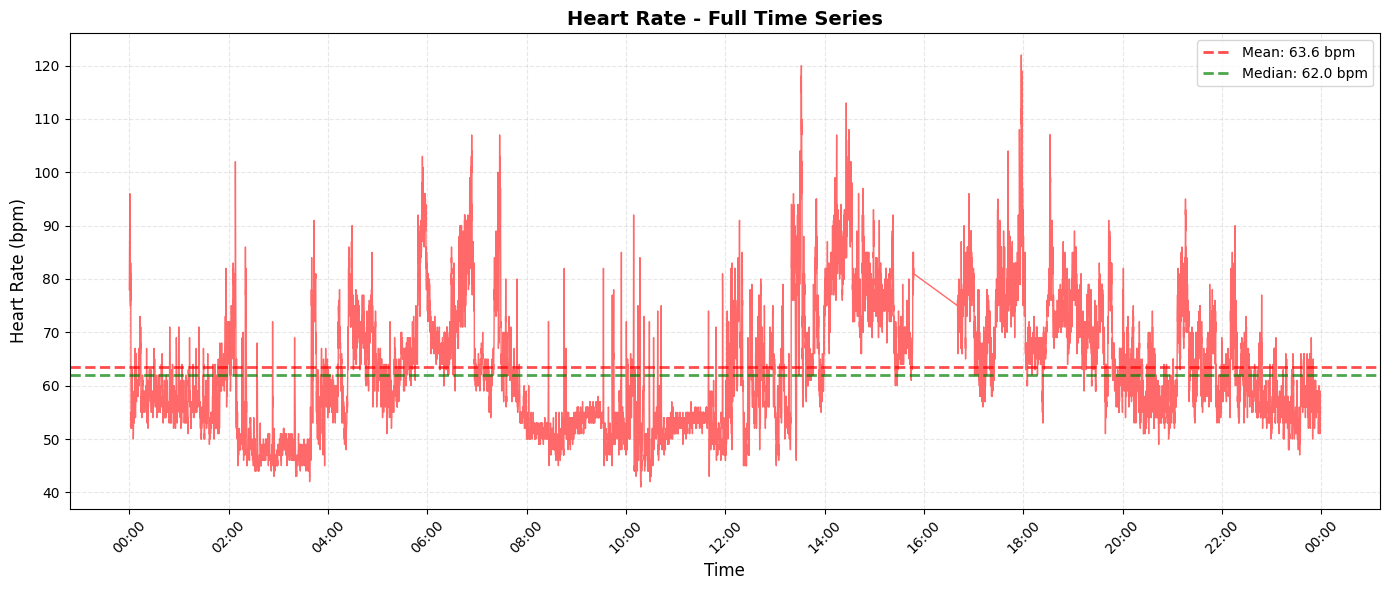

In [10]:
if not df_hr_intra.empty:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot full time series
    ax.plot(df_hr_intra['time'], df_hr_intra['value'], 
            linewidth=1, alpha=0.8, color='#ff4444')
    
    # Add mean and median lines
    mean_hr = df_hr_intra['value'].mean()
    median_hr = df_hr_intra['value'].median()
    ax.axhline(mean_hr, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Mean: {mean_hr:.1f} bpm')
    ax.axhline(median_hr, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Median: {median_hr:.1f} bpm')
    
    ax.set_title('Heart Rate - Full Time Series', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No heart rate data to plot")

---
# 😴 Sleep Analysis

Comprehensive sleep analysis with timeline, stages, efficiency, and nap tracking.

**Note**: Sleep date logic handles overnight sleep correctly:
- Sleep starting 18:00-23:59 → uses that date
- Sleep starting 00:00-05:59 → uses previous day (went to bed previous night)
- Sleep starting 06:00-17:59 → uses that date (daytime/shift sleep)

## Sleep Data Preparation

In [11]:
# ============================================================================
# SLEEP ANALYSIS CONSTANTS & FUNCTIONS
# ============================================================================

# Color scheme for sleep stages
SLEEP_COLORS = {
    'Deep': '#0f172a',      # Midnight Navy — deep and restful
    'Light': '#a5d8ff',     # Pastel Blue — gentle and calming
    'REM': '#c084fc',       # Soft Lavender — dreamy and ethereal
    'Awake': '#fde047'      # Butter Yellow — bright but soft
}

# Map numeric levels to names
LEVEL_DECODE = {
    0: 'Deep',
    1: 'Light',
    2: 'REM',
    3: 'Awake'
}

def _get_main_sleep_session(df_summary):
    """Extract the main sleep session from summary dataframe."""
    if df_summary.empty:
        return None
    
    summary = df_summary.copy()
    if 'isMainSleep' in summary.columns:
        main_sleep = summary[summary['isMainSleep'] == 'True']
        if not main_sleep.empty:
            summary = main_sleep
    
    return summary.iloc[0]

def _prepare_sleep_data(df_levels, df_summary, start_time, end_time):
    """
    Prepare sleep level data for a 24-hour window.
    Adds Awake periods at the start, between sessions, and at the end.
    """
    # Convert all level times to local timezone
    levels = df_levels.copy()
    levels['time'] = levels['time'].dt.tz_convert(TIMEZONE)
    levels['end_time'] = levels['end_time'].dt.tz_convert(TIMEZONE)
    
    # Filter levels for this time window
    levels = levels[
        (levels['time'] >= start_time) & 
        (levels['time'] < end_time)
    ].copy()
    
    if levels.empty:
        return levels
    
    # Sort by time
    levels = levels.sort_values('time').reset_index(drop=True)
    
    # Get all sleep sessions from summary (converted to local timezone)
    summary = df_summary.copy()
    summary['time'] = summary['time'].dt.tz_convert(TIMEZONE)
    summary['end_time'] = summary['end_time'].dt.tz_convert(TIMEZONE)
    
    # Sort sessions by start time
    summary = summary.sort_values('time').reset_index(drop=True)
    
    gaps_to_add = []
    
    # Add Awake period from midnight to first sleep session
    if not summary.empty:
        first_session_start = summary['time'].min()
        
        if start_time < first_session_start:
            gap_seconds = (first_session_start - start_time).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                gaps_to_add.append({
                    'time': start_time,
                    'end_time': first_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # For each sleep session, check if stages data ends before session end_time
    for idx, session in summary.iterrows():
        session_start = session['time']
        session_end = session['end_time']
        
        # Get stages for this session
        session_stages = levels[
            (levels['time'] >= session_start) & 
            (levels['time'] < session_end)
        ]
        
        if not session_stages.empty:
            last_stage_end = session_stages['end_time'].max()
            
            # If stages end before session end, add Awake period
            if last_stage_end < session_end:
                gap_seconds = (session_end - last_stage_end).total_seconds()
                
                if gap_seconds > 30:  # More than 30 seconds
                    gaps_to_add.append({
                        'time': last_stage_end,
                        'end_time': session_end,
                        'level': 3.0,
                        'level_name': 'Awake',
                        'duration_seconds': gap_seconds,
                        'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                    })
    
    # Find gaps BETWEEN sessions (awake time between nap and main sleep, etc.)
    for i in range(len(summary) - 1):
        current_session_end = summary.iloc[i]['end_time']
        next_session_start = summary.iloc[i + 1]['time']
        
        if current_session_end < next_session_start:
            gap_seconds = (next_session_start - current_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                gaps_to_add.append({
                    'time': current_session_end,
                    'end_time': next_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add Awake period from last session end to midnight (end_time)
    if not summary.empty:
        last_session_end = summary['end_time'].max()
        
        if last_session_end < end_time:
            gap_seconds = (end_time - last_session_end).total_seconds()
            
            if gap_seconds > 60:  # More than 1 minute
                gaps_to_add.append({
                    'time': last_session_end,
                    'end_time': end_time,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add all gaps
    if gaps_to_add:
        levels = pd.concat([levels, pd.DataFrame(gaps_to_add)], ignore_index=True)
        levels = levels.sort_values('time').reset_index(drop=True)
    
    return levels

def _plot_sleep_bars(ax, levels):
    """Plot horizontal bars for sleep stages."""
    seen_labels = set()

    for idx, row in levels.iterrows():
        stage = row['level_name']
        color = SLEEP_COLORS.get(stage, '#cccccc')
        duration_hours = row['duration_seconds'] / 3600
        
        label = stage if stage not in seen_labels else None
        seen_labels.add(stage)

        ax.barh(
            y=0,
            width=duration_hours,
            left=row['time'],
            height=0.8,
            color=color,
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9,
            label=label
        )

def _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15):
    """Apply common formatting to timeline axis."""
    # Create a formatter that's timezone-aware
    formatter = DateFormatter('%H:%M', tz=start_time.tz)
    ax.xaxis.set_major_formatter(formatter)
    
    # Calculate time span
    time_span_hours = (end_time - start_time).total_seconds() / 3600
    
    # Set appropriate tick intervals
    if time_span_hours > 6:
        ax.xaxis.set_major_locator(HourLocator(interval=1, tz=start_time.tz))
    elif time_span_hours > 2:
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30), tz=start_time.tz))
    else:
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, interval_minutes), tz=start_time.tz))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.set_xlim(start_time, end_time)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def _add_sleep_legend(ax, location='upper right'):
    """Add standard sleep stage legend to axis."""
    legend_elements = [
        mpatches.Patch(facecolor=SLEEP_COLORS['Deep'], label='Deep', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Light'], label='Light', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['REM'], label='REM', edgecolor='white'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Awake'], label='Awake', edgecolor='white')
    ]
    ax.legend(handles=legend_elements, loc=location, ncol=4, fontsize=11, framealpha=0.9)

print("✅ Sleep analysis functions defined")

✅ Sleep analysis functions defined


In [12]:
# Prepare sleep data if available
if not df_sleep_levels.empty and not df_sleep_summary.empty:
    # Calculate end times for sleep levels
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')
    
    # Parse end time for summary
    if 'endTime' in df_sleep_summary.columns:
        df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])
    
    # Decode numeric levels to names
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(LEVEL_DECODE)
    
    print("✅ Sleep data prepared")
    print(f"   Sleep sessions: {len(df_sleep_summary)}")
    print(f"   Sleep levels: {len(df_sleep_levels)} records")
else:
    print("⚠️  No sleep data available for this date")

✅ Sleep data prepared
   Sleep sessions: 2
   Sleep levels: 32 records


In [13]:
# ============================================================================
# SLEEP VISUALIZATION FUNCTIONS (Part 2 - Main Plotting Functions)
# ============================================================================

def plot_sleep_timeline(df_levels, df_summary):
    """Plot a horizontal timeline showing sleep stages throughout a 24-hour period."""

    if df_levels.empty or df_summary.empty:
        print(f"❌ No sleep data found")
        return None

    # Get the main sleep session to determine the date and window
    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True']
    if main_sleep.empty:
        main_sleep = df_summary.iloc[[0]]  # Fallback to first session

    main_sleep_start = main_sleep.iloc[0]['time']
    sleep_hour = main_sleep_start.hour
    
    # Actual date (for window calculations)
    actual_date = main_sleep_start.date()

    # Determine the "sleep night date" - the date we should LABEL this sleep as
    if sleep_hour >= 18:
        sleep_date = actual_date
    elif sleep_hour < 6:
        sleep_date = (main_sleep_start - pd.Timedelta(days=1)).date()
    else:
        sleep_date = actual_date

    # Extract actual end time
    main_sleep_end = (
        main_sleep.iloc[0].get("endTime") or
        main_sleep.iloc[0].get("end_time") or
        None
    )
    if main_sleep_end is not None:
        main_sleep_end = pd.to_datetime(main_sleep_end)

    # Smart window selection based on main sleep start time
    if sleep_hour < 18:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "midnight-to-midnight"
    else:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE) + pd.Timedelta(hours=12)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "noon-to-noon"

    # Console summary
    print(f"   📅 Sleep Date: {sleep_date.strftime('%A %dth %B %Y')}")
    print(f"   🌙 To Bed: {main_sleep_start.strftime('%H:%M on %A %dth %B')}")
    if main_sleep_end is not None:
        print(f"   ☀️ Woke Up: {main_sleep_end.strftime('%H:%M on %A %dth %B')}\n")

    # Prepare data
    levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    if levels.empty:
        print(f"❌ No sleep level data found for this period")
        return None

    fig, ax = plt.subplots(figsize=(16, 4))
    _plot_sleep_bars(ax, levels)

    # Add "To Bed" and "Up" markers
    ax.axvline(main_sleep_start, linestyle="--", linewidth=1.2)
    ax.text(main_sleep_start, 1.05, "To Bed", ha="center", va="bottom",
            fontsize=10, transform=ax.get_xaxis_transform())

    if main_sleep_end is not None:
        ax.axvline(main_sleep_end, linestyle="--", linewidth=1.2)
        ax.text(main_sleep_end, 1.05, "Up", ha="center", va="bottom",
                fontsize=10, transform=ax.get_xaxis_transform())

    # Generate title
    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        title = (
            f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'
            f'({day1.strftime("%a %d %b")} noon → {day2.strftime("%a %d %b")} noon window)\n'
        )
    else:
        title = f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'

    _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=60)

    # Add legend
    legend_loc = "upper left" if window_type == "noon-to-noon" else "upper right"
    _add_sleep_legend(ax)
    ax.legend(loc=legend_loc)

    plt.tight_layout()
    return fig


def plot_sleep_stages_pie(df_levels, df_summary):
    """Plot a pie chart showing the distribution of sleep stages in minutes."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    start_time = summary['time'].tz_convert(TIMEZONE)
    end_time = summary['end_time'].tz_convert(TIMEZONE)
    
    # Calculate the sleep date
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    
    if levels.empty:
        print(f"❌ No sleep level data found")
        return None
    
    # Calculate minutes per stage
    stage_minutes = levels.groupby('level_name')['duration_seconds'].sum() / 60
    non_awake = stage_minutes.sum() - stage_minutes.get('Awake', 0)
    hours_asleep = round(non_awake / 60, 2)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors_ordered = [SLEEP_COLORS[stage] for stage in stage_minutes.index]
    
    wedges, texts, autotexts = ax.pie(
        stage_minutes,
        labels=[f'{stage}\\n{mins:.0f} min' for stage, mins in stage_minutes.items()],
        autopct='%1.1f%%',
        colors=colors_ordered,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05] * len(stage_minutes)
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
    
    ax.set_title(
        f'Sleep Stage Distribution for {sleep_date.strftime("%A %dth %B %Y")}\n\nTotal Sleep: {hours_asleep} hrs (excluding Awake)\n',
        fontsize=14,
        fontweight='bold',
        pad=12
    )
    
    plt.tight_layout()
    return fig


def display_sleep_efficiency(df_summary):
    """Display sleep efficiency as a simple large text with context."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    # Calculate sleep date
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    efficiency = summary['efficiency']
    minutes_asleep = summary['minutesAsleep']
    minutes_in_bed = summary['minutesInBed']
    
    # Determine color and rating
    if efficiency >= 85:
        color, rating = '#10b981', 'Excellent'
    elif efficiency >= 75:
        color, rating = '#3b82f6', 'Good'
    elif efficiency >= 65:
        color, rating = '#f59e0b', 'Fair'
    else:
        color, rating = '#ef4444', 'Needs Improvement'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis('off')
    
    ax.text(0.5, 0.7, f'{efficiency:.0f}%', 
            ha='center', va='center', fontsize=80, fontweight='bold', color=color)
    ax.text(0.5, 0.5, f'Sleep Efficiency - {rating}', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    ax.text(0.5, 0.35, f'for {sleep_date.strftime("%A %dth %B %Y")}',
            ha='center', va='center', fontsize=14, style='italic', color='#666666')
    ax.text(
        0.5, 0.15,
        f'In bed: {minutes_in_bed:.0f} min / {minutes_in_bed/60:.1f} hours\n\n'
        f'Asleep: {minutes_asleep:.0f} min / {minutes_asleep/60:.1f} hours',
        ha='center', va='center', fontsize=16, style='italic', color=color)
    
    plt.tight_layout()
    return fig


def plot_sleep_stages_bar(df_levels, df_summary):
    """Plot a single vertical stacked bar showing hours of each sleep stage."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    # Calculate the sleep date
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    # Use summary data directly
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    # Convert to hours
    stage_hours = {stage: mins / 60 for stage, mins in stage_minutes.items()}
    
    # Calculate totals
    time_asleep = stage_hours['Deep'] + stage_hours['Light'] + stage_hours['REM']
    time_in_bed = summary['minutesInBed'] / 60
    
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 10))
    
    stage_order = ['Deep', 'Light', 'REM', 'Awake']
    bottom = 0
    
    for stage in stage_order:
        hours = stage_hours[stage]
        color = SLEEP_COLORS[stage]
        
        ax.bar(0, hours, bottom=bottom, color=color, edgecolor='white',
               linewidth=2, width=0.5, label=f'{stage}: {hours:.1f}h')
        
        # Only show label if segment is large enough
        if hours > 0.15:
            ax.text(0, bottom + hours/2, f'{hours:.1f}h',
                   ha='center', va='center', fontweight='bold', 
                   fontsize=14, color='white')
        
        bottom += hours
    
    ax.set_ylabel('Hours', fontsize=14, fontweight='bold')
    ax.set_title(f'Sleep Composition for {sleep_date.strftime("%A %dth %B %Y")}',
                fontsize=16, fontweight='bold', pad=25)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Set y-axis limit to add space for labels
    ax.set_ylim(0, time_in_bed * 1.25)
    
    # Add labels above bar
    label_offset = time_in_bed * 0.08
    ax.text(0, time_in_bed + label_offset * 2, f'Time in Bed: {time_in_bed:.1f}h',
           ha='center', fontweight='bold', fontsize=13, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.3))
    ax.text(0, time_in_bed + label_offset * 0.5, f'Time Asleep: {time_asleep:.1f}h',
           ha='center', fontweight='bold', fontsize=13,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    return fig


def plot_naps_timeline(df_levels, df_summary):
    """Plot individual timelines for all naps (isMainSleep == 'False')."""

    if df_summary.empty:
        print(f"❌ No sleep summary found")
        return None

    # Check if isMainSleep column exists
    if 'isMainSleep' not in df_summary.columns:
        print(f"❌ No isMainSleep column found in summary data")
        return None

    # Filter for naps only
    naps = df_summary[df_summary['isMainSleep'] == 'False'].copy()

    if naps.empty:
        print(f"😴 No naps found for this date")
        return None

    print(f"💤 Found {len(naps)} nap(s)")

    # Create a subplot for each nap
    fig, axes = plt.subplots(len(naps), 1, figsize=(16, 3 * len(naps)))
    if len(naps) == 1:
        axes = [axes]  # Make it a list for consistent iteration

    for idx, (nap_idx, nap) in enumerate(naps.iterrows()):
        ax = axes[idx]

        # Get nap time window (add 30 min buffer on each side for context)
        start_time = nap['time'] - pd.Timedelta(minutes=30)
        end_time = nap['end_time'] + pd.Timedelta(minutes=30)

        # Prepare data for this nap window
        levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)

        if levels.empty:
            ax.text(0.5, 0.5, 'No detailed stage data available',
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Nap {idx+1} - No Data', fontweight='bold')
            continue

        # Plot the sleep bars
        _plot_sleep_bars(ax, levels)

        # Format the axis
        nap_duration = nap['minutesInBed']
        nap_asleep = nap['minutesAsleep']
        efficiency = nap.get('efficiency', 0)

        title = (f'Naps for {nap["time"].strftime("%A %dth %B %Y")}\n\n'
                 f'Nap {idx+1} - {nap["time"].strftime("%H:%M")} to {nap["end_time"].strftime("%H:%M")} - Duration: {nap_duration:.0f} min in bed | Asleep: {nap_asleep:.0f} min | Efficiency: {efficiency:.0f}%\n')

        _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15)

        # Add legend to first plot only
        if idx == 0:
            _add_sleep_legend(ax, location='upper right')

    plt.tight_layout()
    return fig

print("✅ Sleep plotting functions defined")

✅ Sleep plotting functions defined


## Plot 1: Sleep Timeline

## Main Sleep Timeline

   📅 Sleep Date: Tuesday 02th December 2025
   🌙 To Bed: 07:36 on Tuesday 02th December
   ☀️ Woke Up: 12:05 on Tuesday 02th December



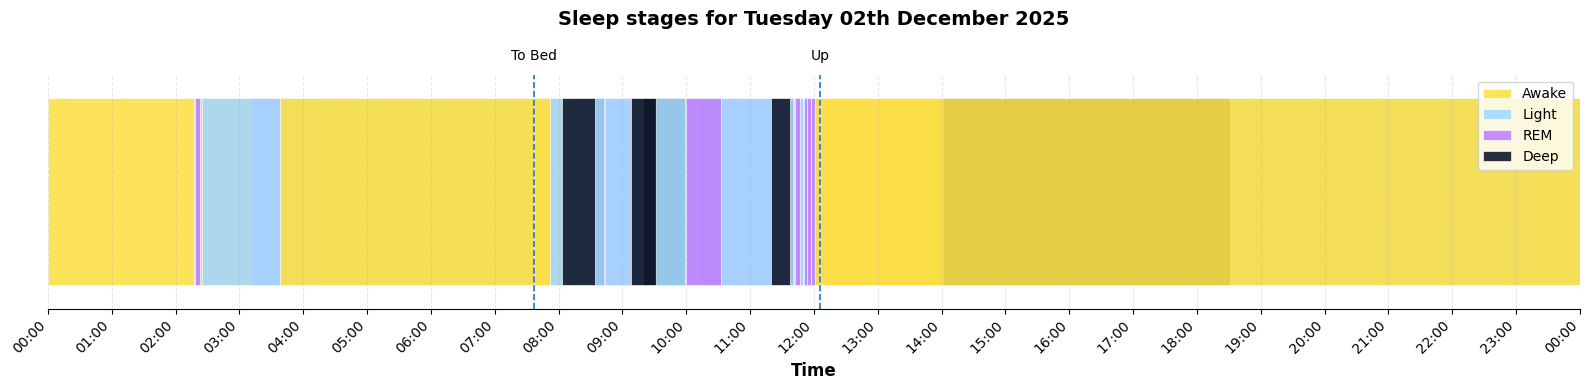

In [14]:
if not df_sleep_levels.empty and not df_sleep_summary.empty:
    fig_sleep_timeline = plot_sleep_timeline(df_sleep_levels, df_sleep_summary)
    if fig_sleep_timeline is not None:
        plt.show()
else:
    print("⚠️  No sleep data to plot")

## Nap Timeline

💤 Found 1 nap(s)


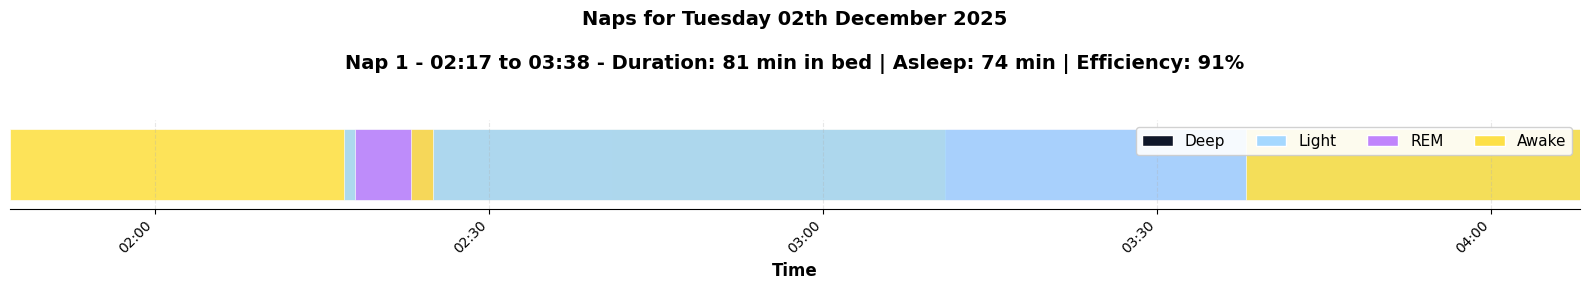

In [15]:
fig4 = plot_naps_timeline(df_sleep_levels, df_sleep_summary)

## Sleep Stages Pie Chart

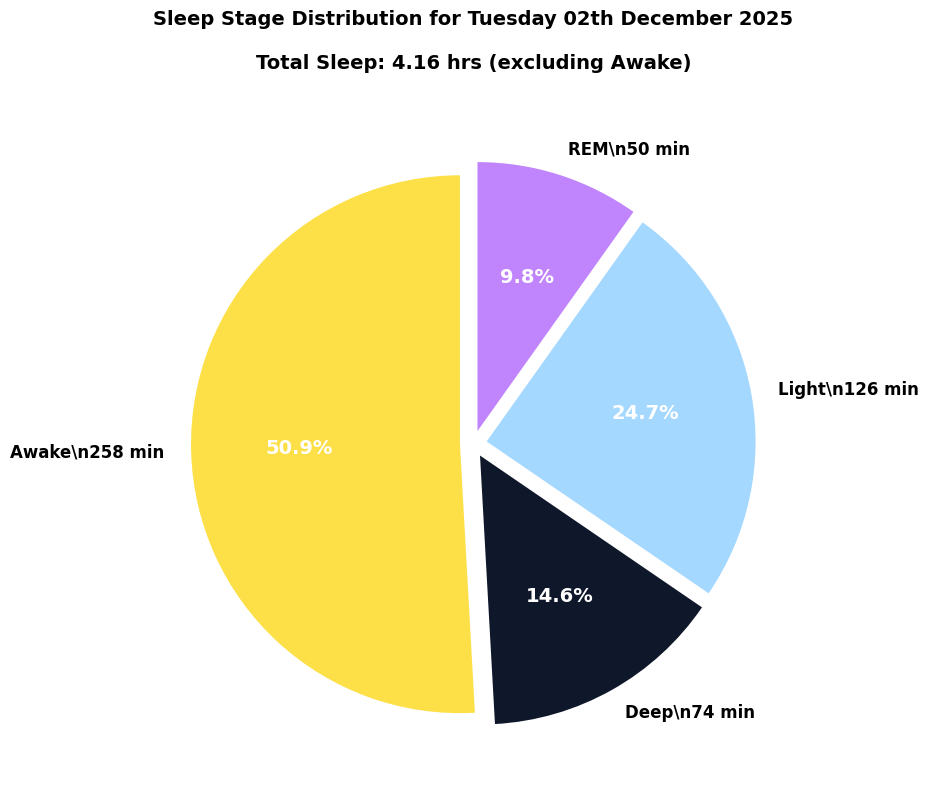

In [16]:
if not df_sleep_levels.empty and not df_sleep_summary.empty:
    fig_sleep_pie = plot_sleep_stages_pie(df_sleep_levels, df_sleep_summary)
    if fig_sleep_pie is not None:
        plt.show()
else:
    print("⚠️  No sleep data to plot")

## Sleep Composition Bar

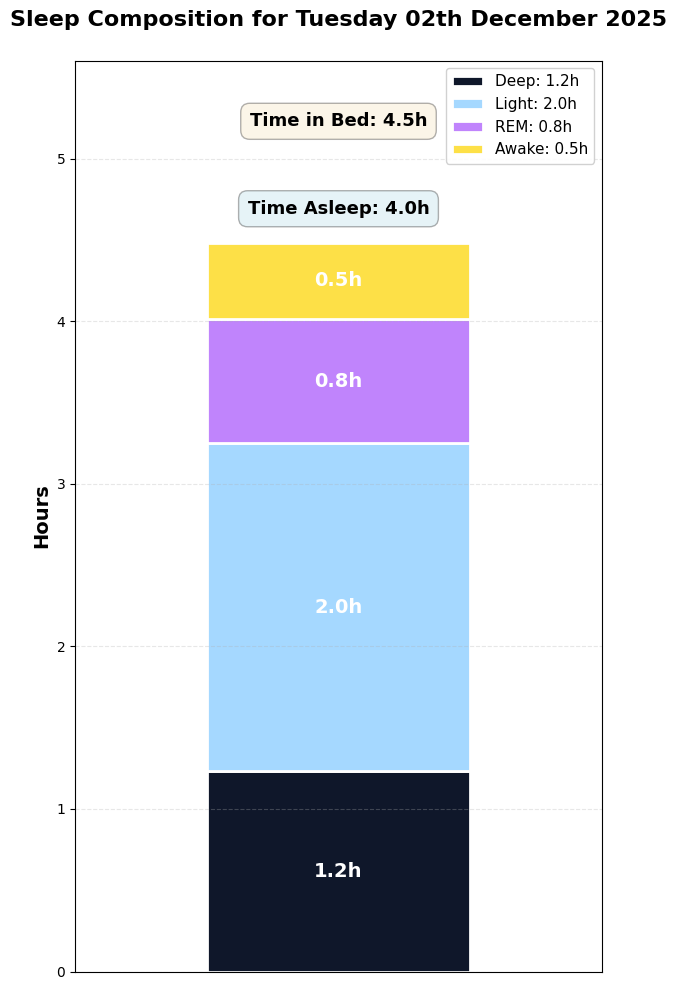

In [17]:
if not df_sleep_levels.empty and not df_sleep_summary.empty:
    fig_sleep_bar = plot_sleep_stages_bar(df_sleep_levels, df_sleep_summary)
    if fig_sleep_bar is not None:
        plt.show()
else:
    print("⚠️  No sleep data to plot")

## Sleep Efficiency

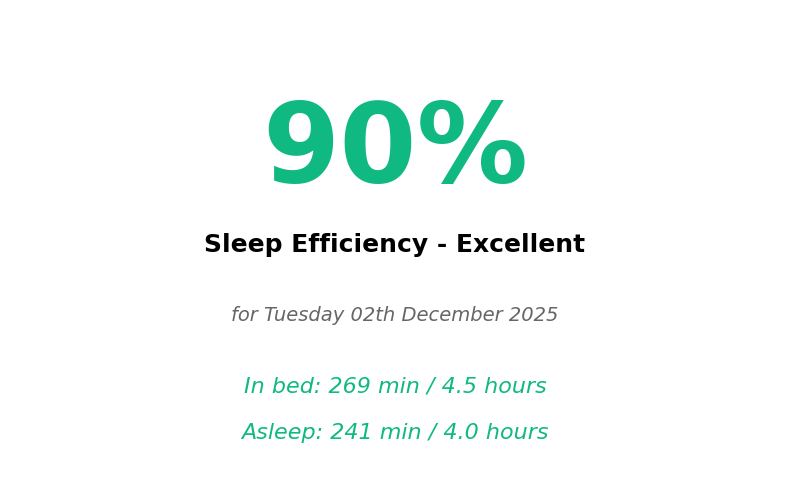

In [18]:
if not df_sleep_summary.empty:
    fig_sleep_efficiency = display_sleep_efficiency(df_sleep_summary)
    if fig_sleep_efficiency is not None:
        plt.show()
else:
    print("⚠️  No sleep data to plot")

---
# 👟 Steps & Activity Analysis

Step patterns, activity intensity, and correlation with heart rate.

In [19]:
# ============================================================================
# STEPS ANALYSIS FUNCTIONS
# ============================================================================

# Constants for consistent styling
COLOR_HR = '#ff4444'
COLOR_STEPS = '#4a90e2'
BAR_WIDTH_TIMEDELTA = 1 / 1440  # 1 minute in days for bar width

def plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra, tz='Europe/London'):
    """
    Plot steps and heart rate on dual y-axes to show correlation.
    
    Args:
        df_hr_intra: Intraday heart rate DataFrame
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    if df_hr_intra.empty or df_steps_intra.empty:
        print("⚠️  Missing heart rate or steps data")
        return None
    
    # Convert to local timezone if needed
    df_hr = df_hr_intra.copy()
    df_steps = df_steps_intra.copy()
    
    if df_hr['time'].dt.tz is not None:
        df_hr['time'] = df_hr['time'].dt.tz_convert(tz)
    if df_steps['time'].dt.tz is not None:
        df_steps['time'] = df_steps['time'].dt.tz_convert(tz)
    
    # Extract date for the title
    date_str = df_hr['time'].iloc[0].strftime('%A, %dth %B')
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot heart rate on primary y-axis
    ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color=COLOR_HR)
    ax1.plot(df_hr['time'], df_hr['value'], color=COLOR_HR, linewidth=1.5, 
             label='Heart Rate', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=COLOR_HR)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Create secondary y-axis for steps
    ax2 = ax1.twinx()
    ax2.set_ylabel('Steps per Minute', fontsize=12, fontweight='bold', color=COLOR_STEPS)
    
    # Plot steps as bars
    ax2.bar(df_steps['time'], df_steps['value'], width=BAR_WIDTH_TIMEDELTA, 
            color=COLOR_STEPS, alpha=0.6, label='Steps/min')
    ax2.tick_params(axis='y', labelcolor=COLOR_STEPS)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Title with date
    plt.title(f"Steps vs Heart Rate Throughout the Day - {date_str}",
              fontsize=14, fontweight='bold', pad=20)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig


def plot_hourly_activity_heatmap(df_steps_intra, tz='Europe/London'):
    """
    Show hourly activity levels as a heatmap-style bar chart.
    
    Args:
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    if df_steps_intra.empty:
        print("⚠️  No steps data available")
        return None
    
    # Convert to local timezone
    df_steps = df_steps_intra.copy()
    if df_steps['time'].dt.tz is not None:
        df_steps['time'] = df_steps['time'].dt.tz_convert(tz)
    
    # Extract date and hour
    date_str = df_steps['time'].iloc[0].strftime('%A, %dth %B')
    df_steps['hour'] = df_steps['time'].dt.hour
    
    # Calculate steps per hour
    hourly_steps = df_steps.groupby('hour', as_index=False)['value'].sum()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure all 24 hours are present
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create color map based on activity level
    max_steps = hourly_steps['steps'].max()
    if max_steps > 0:
        colors = plt.cm.YlOrRd(hourly_steps['steps'] / max_steps)
    else:
        colors = ['lightgray'] * 24
    
    # Plot bars
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar, steps in zip(bars, hourly_steps['steps']):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(steps)}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Steps', fontsize=12, fontweight='bold')
    ax.set_title(f'Hourly Activity Distribution for {date_str}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    return fig

print("✅ Steps analysis functions defined")

✅ Steps analysis functions defined


## Plot 1

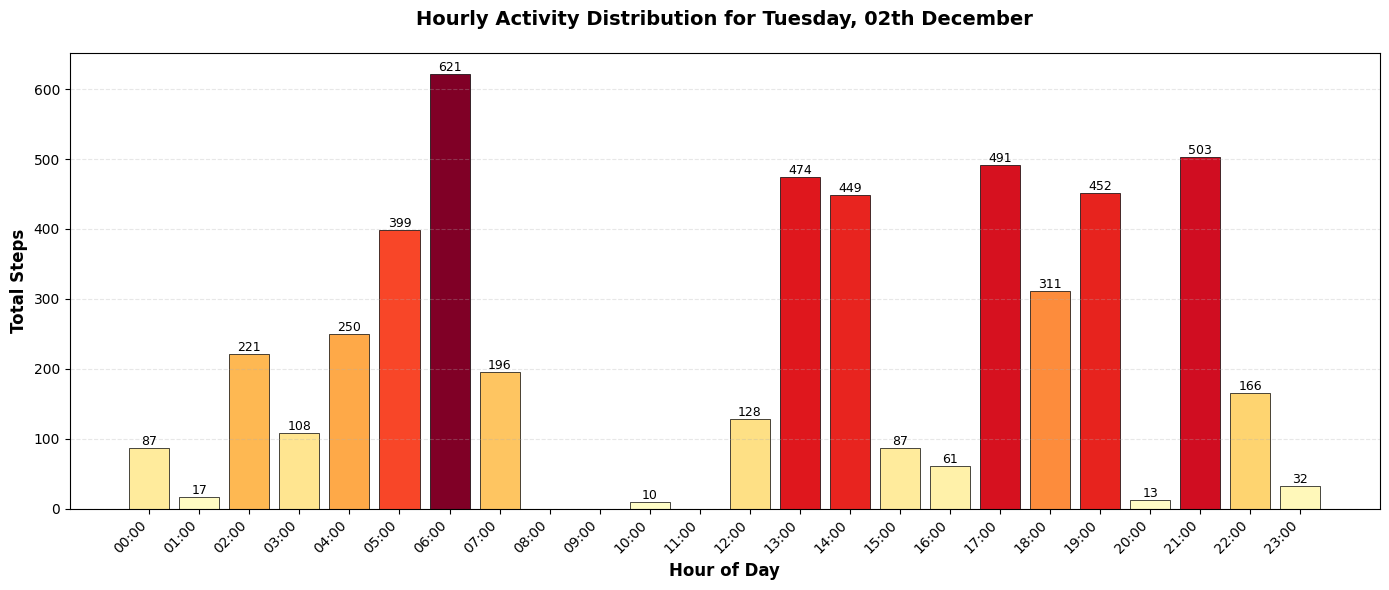

In [20]:
if not df_steps_intra.empty:
    fig_hourly = plot_hourly_activity_heatmap(df_steps_intra, TIMEZONE)
    if fig_hourly is not None:
        plt.show()
else:
    print("⚠️  No steps data available for hourly heatmap")

## Plot 2

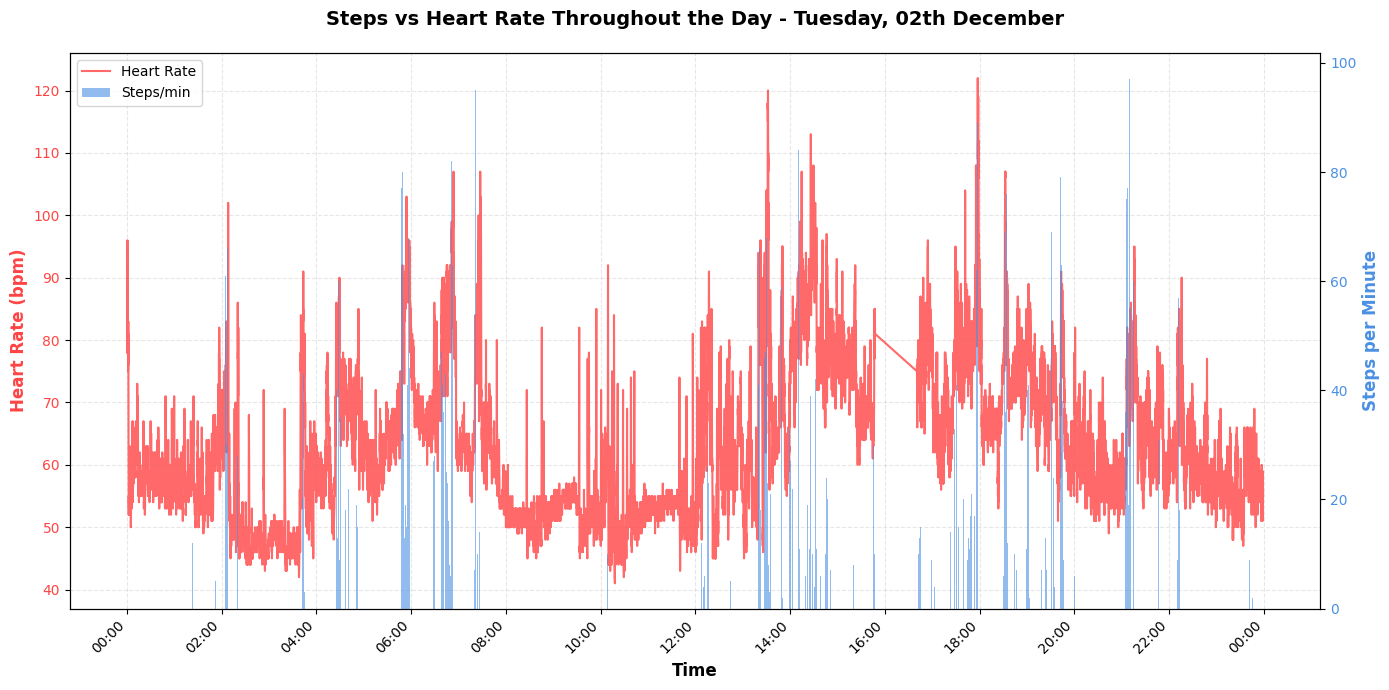

In [21]:
if not df_hr_intra.empty and not df_steps_intra.empty:
    fig_steps_hr = plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra, TIMEZONE)
    if fig_steps_hr is not None:
        plt.show()
else:
    print("⚠️  Missing heart rate or steps data for correlation plot")

In [22]:
# ============================================================================
# RECOVERY & VARIOUS METRICS FUNCTIONS
# ============================================================================

def plot_activity_hr_correlation(df_hr_intra, df_steps_intra, 
                                  df_sedentary, df_light, df_fairly, df_very):
    """
    Activity level distribution showing minutes breakdown and proportion.
    
    Creates a 2-panel dashboard showing:
    1. Activity minutes breakdown (bar chart)
    2. Activity time proportion (pie chart)
    
    Args:
        df_hr_intra: Intraday heart rate DataFrame (not used but kept for compatibility)
        df_steps_intra: Intraday steps DataFrame (not used but kept for compatibility)
        df_sedentary: Daily sedentary minutes DataFrame
        df_light: Daily lightly active minutes DataFrame
        df_fairly: Daily fairly active minutes DataFrame
        df_very: Daily very active minutes DataFrame
    
    Returns:
        matplotlib.figure.Figure: The generated 2-panel figure
    """
    # Extract activity minutes
    sedentary_min = df_sedentary['value'].iloc[0] if not df_sedentary.empty else 0
    light_min = df_light['value'].iloc[0] if not df_light.empty else 0
    fairly_min = df_fairly['value'].iloc[0] if not df_fairly.empty else 0
    very_min = df_very['value'].iloc[0] if not df_very.empty else 0
    
    # Create figure with 2 panels side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ========================================================================
    # Panel 1: Activity Minutes Breakdown
    # ========================================================================
    activity_data = {
        'Sedentary': sedentary_min,
        'Light': light_min,
        'Fairly Active': fairly_min,
        'Very Active': very_min
    }
    
    colors_activity = ['#e0e0e0', '#ffeb99', '#ffb347', '#ff6b6b']
    bars = ax1.bar(activity_data.keys(), activity_data.values(), 
                   color=colors_activity, edgecolor='black', linewidth=1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)} min', ha='center', va='bottom', fontsize=11)
    
    ax1.set_ylabel('Minutes', fontsize=12, fontweight='bold')
    ax1.set_title('Activity Level Distribution', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # ========================================================================
    # Panel 2: Activity Pie Chart
    # ========================================================================
    # Only include non-zero values
    pie_data = {k: v for k, v in activity_data.items() if v > 0}
    
    if pie_data:
        wedges, texts, autotexts = ax2.pie(pie_data.values(), 
                                            labels=pie_data.keys(),
                                            colors=colors_activity,
                                            autopct='%1.1f%%',
                                            startangle=90)
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(11)
    
    ax2.set_title('Activity Time Proportion', fontsize=13, fontweight='bold')
    
    plt.suptitle('Daily Activity Analysis', fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    return fig

print("✅ Recovery & various metrics functions defined")

✅ Recovery & various metrics functions defined


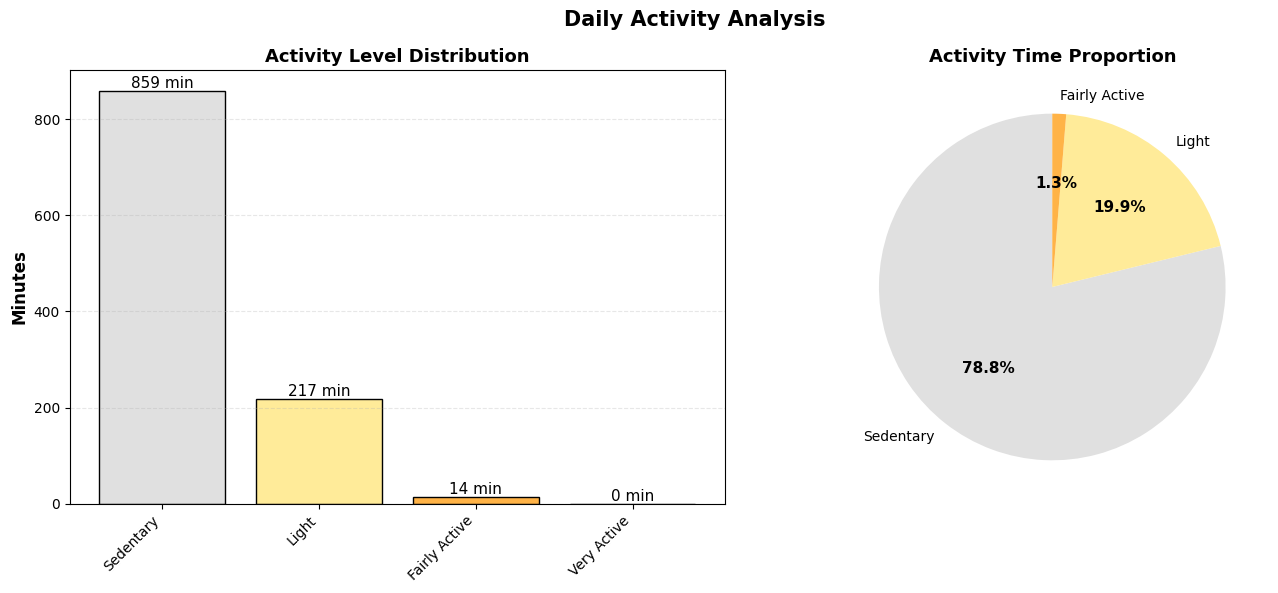

In [23]:
# Extract activity-related DataFrames
df_sedentary = dfs.get('Activity-minutesSedentary', pd.DataFrame())
df_light = dfs.get('Activity-minutesLightlyActive', pd.DataFrame())
df_fairly = dfs.get('Activity-minutesFairlyActive', pd.DataFrame())
df_very = dfs.get('Activity-minutesVeryActive', pd.DataFrame())

if not df_hr_intra.empty and not df_steps_intra.empty:
    fig_activity_hr = plot_activity_hr_correlation(
        df_hr_intra, df_steps_intra,
        df_sedentary, df_light, df_fairly, df_very
    )
    plt.show()
else:
    print("⚠️  Missing heart rate or steps data for activity correlation plot")

## Plot 1: Activity & Heart Rate Correlation

---
# 🔋 Recovery & Various Metrics

HRV, recovery metrics, and comprehensive activity analysis.

In [24]:
# Extract HR-related DataFrames
df_hrv = dfs.get('HRV', pd.DataFrame())
df_hr_zones = dfs.get('HR_Zones', pd.DataFrame())
df_resting_hr = dfs.get('RestingHR', pd.DataFrame())

if not df_hr_intra.empty:
    print("📊 HEART RATE STATISTICS")
    print("=" * 60)
    print(f"Total Records:      {len(df_hr_intra):,}")
    print(f"Date:               {df_hr_intra['time'].dt.date.iloc[0]}")
    print(f"Time Range:         {df_hr_intra['time'].min().strftime('%H:%M:%S')} - {df_hr_intra['time'].max().strftime('%H:%M:%S')}")
    print(f"\n📈 Descriptive Statistics:")
    print(f"Mean:               {df_hr_intra['value'].mean():.1f} bpm")
    print(f"Median:             {df_hr_intra['value'].median():.1f} bpm")
    print(f"Std Dev:            {df_hr_intra['value'].std():.1f} bpm")
    print(f"Min:                {df_hr_intra['value'].min():.0f} bpm")
    print(f"Max:                {df_hr_intra['value'].max():.0f} bpm")
    print(f"Range:              {df_hr_intra['value'].max() - df_hr_intra['value'].min():.0f} bpm")
    
    # HRV Statistics
    if not df_hrv.empty:
        print(f"\n💓 HRV METRICS")
        print("=" * 60)
        print(f"Daily RMSSD:        {df_hrv['dailyRmssd'].iloc[0]:.1f} ms")
        print(f"Deep Sleep RMSSD:   {df_hrv['deepRmssd'].iloc[0]:.1f} ms")
    
    # Heart Rate Zones
    if not df_hr_zones.empty:
        print(f"\n🎯 TIME IN HEART RATE ZONES")
        print("=" * 60)
        total_minutes = df_hr_zones[['Out of Range', 'Fat Burn', 'Cardio', 'Peak']].sum().sum()
        for zone in ['Out of Range', 'Fat Burn', 'Cardio', 'Peak']:
            minutes = df_hr_zones[zone].iloc[0]
            percentage = (minutes / total_minutes * 100) if total_minutes > 0 else 0
            print(f"{zone:20s} {minutes:6.0f} min ({percentage:5.1f}%)")
        print(f"{'Total':20s} {total_minutes:6.0f} min")
    
    # Resting Heart Rate
    if not df_resting_hr.empty:
        print(f"\n❤️  RESTING HEART RATE")
        print("=" * 60)
        print(f"Resting HR:         {df_resting_hr['value'].iloc[0]:.0f} bpm")
else:
    print("⚠️  No heart rate data available")

📊 HEART RATE STATISTICS
Total Records:      39,228
Date:               2025-12-02
Time Range:         00:00:00 - 23:58:58

📈 Descriptive Statistics:
Mean:               63.6 bpm
Median:             62.0 bpm
Std Dev:            11.6 bpm
Min:                41 bpm
Max:                122 bpm
Range:              81 bpm

💓 HRV METRICS
Daily RMSSD:        0.0 ms
Deep Sleep RMSSD:   62.7 ms

🎯 TIME IN HEART RATE ZONES
Out of Range           1435 min ( 99.7%)
Fat Burn                  5 min (  0.3%)
Cardio                    0 min (  0.0%)
Peak                      0 min (  0.0%)
Total                  1440 min

❤️  RESTING HEART RATE
Resting HR:         56 bpm


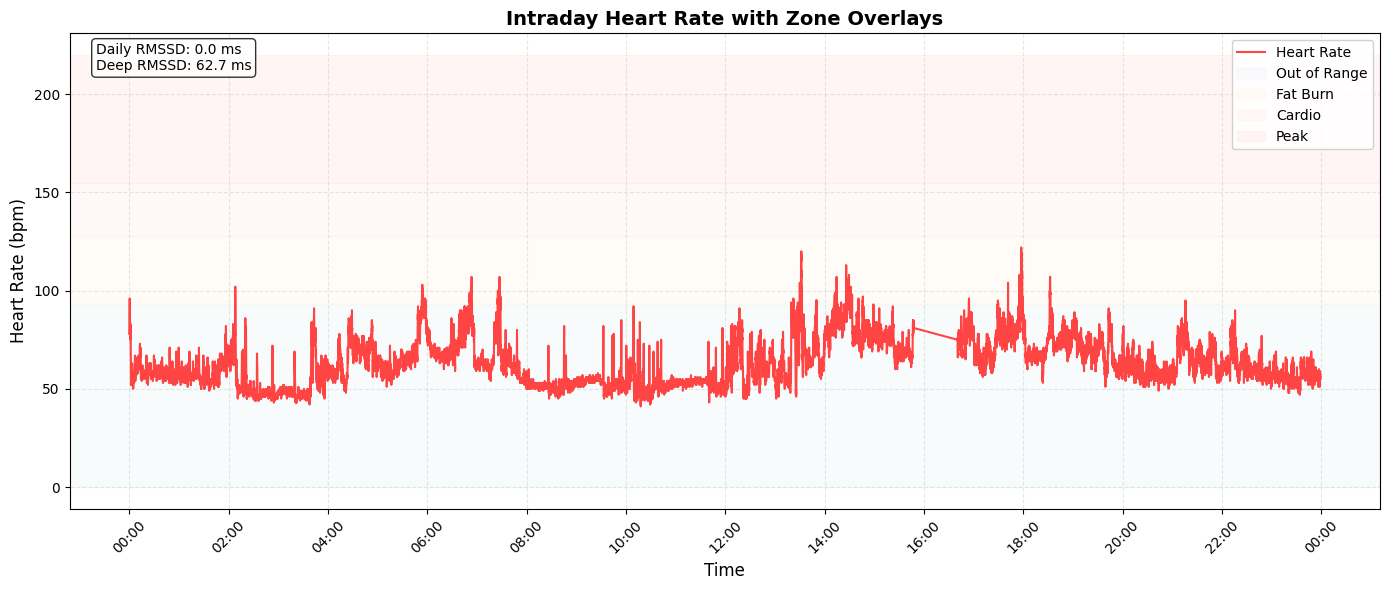

In [25]:
if not df_hr_intra.empty:
    fig1 = plot_hr_with_zones(df_hr_intra, df_hrv)
    plt.show()
else:
    print("⚠️  No heart rate data to plot")

---
## 📝 Notes

Add your observations here:
- 
- 
- 